In [9]:
import timeit
import tracemalloc
import os
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
import regex  # For Test 5
import sys

# --- 1. CORE HELPER FUNCTIONS ---

def get_filepath_input():
    """Asks the user for the genome file path."""
    default_path = "NC_000913.3.fna"
    print("\n--- Configuration ---")
    path = input(f"Enter path to .fna file [Default: '{default_path}']: ").strip()
    
    if path == "":
        path = default_path
    
    if not os.path.exists(path):
        print(f"\nERROR: File not found at '{path}'")
        print("Please check the path and try again.")
        return None
    
    print(f"Using genome: {path}")
    return path

def get_genome_from_file(filepath, slice_size=None):
    """Loads a genome sequence from a local FASTA (.fna) file."""
    if not os.path.exists(filepath):
        print(f"Error: File not found at {filepath}")
        return None
        
    try:
        record = SeqIO.read(filepath, "fasta")
        genome_text = str(record.seq).upper()
    except ValueError:
        all_seqs = []
        try:
            for record in SeqIO.parse(filepath, "fasta"):
                all_seqs.append(str(record.seq).upper())
            genome_text = "".join(all_seqs)
        except Exception as e:
            print(f"Could not parse multi-sequence FASTA: {e}")
            return None
    except Exception as e:
        print(f"An error occurred while reading the file: {e}")
        return None

    if slice_size:
        if slice_size > len(genome_text):
            print(f"Info: Slice size {slice_size} is larger than genome {len(genome_text)}. Using full genome.")
            return genome_text
        # Ensure we don't slice beyond the file length
        return genome_text[:min(slice_size, len(genome_text))]
    else:
        return genome_text

def fuzzy_levenshtein_search(text, pattern, k):
    """Finds matches with at most 'k' Levenshtein edits."""
    n = len(text)
    m = len(pattern)
    matches = []
    # Space Optimization: O(n)
    previous_row = [0] * (n + 1) 

    for i in range(1, m + 1):
        current_row = [i] * (n + 1)
        for j in range(1, n + 1):
            deletion = previous_row[j] + 1
            insertion = current_row[j-1] + 1
            substitution = previous_row[j-1] + (0 if pattern[i-1] == text[j-1] else 1)
            current_row[j] = min(deletion, insertion, substitution)
        
        if i == m: # On the last row, check for matches
            for j in range(1, n + 1):
                if current_row[j] <= k:
                    matches.append(j - 1)
        previous_row = current_row
        
    return matches

def regex_fuzzy_search(text, pattern, k):
    """Performs a fuzzy search using the 'regex' library (for Test 5)."""
    # {e<=k} is the regex syntax for "at most k errors"
    matches = regex.findall(f"({pattern}){{e<={k}}}", text, overlapped=True)
    return matches

# --- 2. PLOTTING FUNCTIONS ---

def plot_pattern_analysis_results(df, k, fixed_slice_size):
    """Plots results for Test 2 (Pattern Length)."""
    if df.empty:
        print("No data to plot.")
        return

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    fig.suptitle(f"Fuzzy Search Performance vs. Pattern Length (m)\nFixed Text Size: {fixed_slice_size:,} bp (k={k})", fontsize=16)

    ax1.plot(df["pattern_length"], df["avg_time_s"], 'bo-', label="Average Time")
    ax1.set_title("Time Analysis (Should be Linear)")
    ax1.set_xlabel("Pattern Length (m)") 
    ax1.set_ylabel("Average Time (seconds)")
    ax1.grid(True)
    ax1.legend()

    # Note: Memory for O(n) optimized algo should be flat vs. pattern length
    ax2.plot(df["pattern_length"], df["peak_memory_mb"], 'ro-', label="Peak Memory")
    ax2.set_title("Memory Analysis (Should be Flat)")
    ax2.set_xlabel("Pattern Length (m)")
    ax2.set_ylabel("Peak Memory (MB)")
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    print("\nDisplaying analysis plots...")
    plt.show()

def plot_k_analysis_results(df):
    """Plots results for Test 3 (K-Threshold)."""
    if df.empty:
        print("No data to plot.")
        return

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    fig.suptitle(f"Fuzzy Search Performance vs. K-Threshold", fontsize=16)

    ax1.plot(df["k_threshold"], df["avg_time_s"], 'bo-', label="Average Time")
    ax1.plot(df["k_threshold"], df["peak_memory_mb"], 'ro-', label="Peak Memory (MB)")
    ax1.set_title("Time & Memory Analysis (Should be Flat)")
    ax1.set_xlabel("K-Threshold") 
    ax1.set_ylabel("Time (s) / Memory (MB)")
    ax1.grid(True)
    ax1.legend()

    ax2.plot(df["k_threshold"], df["match_count"], 'gs-', label="Match Count")
    ax2.set_title("Match Count (Should Increase)")
    ax2.set_xlabel("K-Threshold")
    ax2.set_ylabel("Number of Matches Found")
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    print("\nDisplaying analysis plots...")
    plt.show()

def plot_scaling_results(df, title):
    """Plots results for Test 1 (Slice Size) and Test 4 (Data Comp)."""
    if df.empty:
        print("No data to plot.")
        return

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    fig.suptitle(f"Scaling Performance: {title}", fontsize=16)

    # --- Plot 1: Time vs. Size ---
    ax1.plot(df["slice_size"], df["avg_time_s"], 'bo-', label="Average Time")
    ax1.set_title("Time Analysis (Should be Linear)")
    ax1.set_xlabel("Genome Slice Size (Base Pairs)")
    ax1.set_ylabel("Average Time (seconds)")
    ax1.grid(True)
    ax1.legend()
    # Format x-axis to use commas
    ax1.get_xaxis().set_major_formatter(
        plt.FuncFormatter(lambda x, p: format(int(x), ','))
    )

    # --- Plot 2: Memory vs. Size ---
    ax2.plot(df["slice_size"], df["peak_memory_mb"], 'ro-', label="Peak Memory")
    ax2.set_title("Memory Analysis (Should be Linear)")
    ax2.set_xlabel("Genome Slice Size (Base Pairs)")
    ax2.set_ylabel("Peak Memory (MB)")
    ax2.grid(True)
    ax2.legend()
    ax2.get_xaxis().set_major_formatter(
        plt.FuncFormatter(lambda x, p: format(int(x), ','))
    )

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    print(f"\nDisplaying plots for {title}...")
    plt.show()

def plot_comparison_results(df):
    """Plots results for Test 5 (Regex Comparison)."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    fig.suptitle("Performance: Python Levenshtein vs. C-Optimized 'regex'", fontsize=16)

    ax1.plot(df["slice_size"], df["time_levenshtein"], 'b-o', label="Levenshtein")
    ax1.plot(df["slice_size"], df["time_regex"], 'g-s', label="'regex' Library")
    ax1.set_title("Time Analysis")
    ax1.set_ylabel("Average Time (seconds)")
    ax1.set_yscale('log') # Use a log scale, regex will be MUCH faster
    ax1.grid(True, which="both")
    ax1.legend()

    ax2.plot(df["slice_size"], df["mem_levenshtein"], 'b-o', label="Levenshtein (O(n) optimized)")
    ax2.plot(df["slice_size"], df["mem_regex"], 'g-s', label="'regex' Library")
    ax2.set_title("Memory Analysis")
    ax2.set_xlabel("Genome Slice Size (Base Pairs)")
    ax2.set_ylabel("Peak Memory (MB)")
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    print("\nDisplaying comparison plots...")
    plt.show()


# --- 3. HELPER FUNCTION FOR RUNNING SCALING ---
#    (Used in Test 1 and Test 4)

def run_scaling_analysis(filepath, pattern, k, slice_sizes):
    """Runs time/memory analysis across different slice sizes."""
    results = []
    
    # Check if we can load the max size requested
    full_text_check = get_genome_from_file(filepath, max(slice_sizes))
    if not full_text_check:
        print(f"Error: Could not load data up to {max(slice_sizes)} bp.")
        return pd.DataFrame(results) # Return empty
    if len(full_text_check) < max(slice_sizes):
        print(f"Warning: Full genome ({len(full_text_check)} bp) is smaller than max slice ({max(slice_sizes)} bp).")
        print("Adjusting test sizes.")
        slice_sizes = [s for s in slice_sizes if s <= len(full_text_check)]

    for size in slice_sizes:
        print(f"\n--- Testing Slice Size: {size:,} bp ---")
        # We re-load the slice each time
        genome_text = get_genome_from_file(filepath, size)
        if not genome_text:
            print(f"Skipping size {size}, could not load data.")
            continue
        
        print("Running time analysis...")
        t = timeit.Timer(lambda: fuzzy_levenshtein_search(genome_text, pattern, k))
        # Dynamic number of runs
        num_runs = 3
        if size <= 50000: num_runs = 5
        if size <= 10000: num_runs = 10
        
        total_time = t.timeit(number=num_runs)
        avg_time = total_time / num_runs
        print(f"Avg Time: {avg_time:.6f} s (over {num_runs} runs)")

        print("Running memory analysis...")
        tracemalloc.start()
        fuzzy_levenshtein_search(genome_text, pattern, k)
        _, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        peak_mb = peak / 1024**2
        print(f"Peak Memory: {peak_mb:.4f} MB")
        
        results.append({
            "slice_size": size,
            "avg_time_s": avg_time,
            "peak_memory_mb": peak_mb
        })
    return pd.DataFrame(results)


# --- 4. TEST-RUNNER FUNCTIONS ---

def run_test_1_slice_size(GENOME_FILEPATH):
    """Tests the impact of slice size 'n'."""
    print("\n[--- Test 1: Impact of Slice Size (n) ---]")
    PATTERN = "TATAAT"
    K_THRESHOLD = 1
    # Increased range: 10K to 1M in 20K increments
    SLICE_SIZES = list(range(10000, 1000001, 20000))
    print(f"Testing {len(SLICE_SIZES)} different slice sizes (from {SLICE_SIZES[0]:,} to {SLICE_SIZES[-1]:,})...")
    
    df = run_scaling_analysis(GENOME_FILEPATH, PATTERN, K_THRESHOLD, SLICE_SIZES)
    
    if not df.empty:
        print("\n--- Final Results Table (Test 1) ---")
        print(df)
        plot_scaling_results(df, "Fuzzy Search vs. Slice Size (n)")
    else:
        print("Test 1 failed to produce results.")

def run_test_2_pattern_length(GENOME_FILEPATH):
    """Tests the impact of pattern length 'm'."""
    print("\n[--- Test 2: Impact of Pattern Length (m) ---]")
    FIXED_SLICE_SIZE = 100000 # Increased from 90K
    # Expanded range: 5 to 100
    PATTERN_LENGTHS = [5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100] 
    K_THRESHOLD = 1
    
    results = []
    full_text = get_genome_from_file(GENOME_FILEPATH, FIXED_SLICE_SIZE)
    if not full_text:
        print("Could not load genome file. Exiting test.")
        return

    print(f"Starting analysis on fixed text size: {len(full_text):,} bp")
    
    for length in PATTERN_LENGTHS:
        base_pattern = "TATAAT"
        pattern = (base_pattern * (length // 6 + 1))[:length]
        
        print(f"\n--- Testing Pattern Length: {length} bp ---")
        
        print("Running time analysis...")
        t = timeit.Timer(lambda: fuzzy_levenshtein_search(full_text, pattern, K_THRESHOLD))
        num_runs = max(3, 150 // length)
        total_time = t.timeit(number=num_runs)
        avg_time = total_time / num_runs
        print(f"Avg Time: {avg_time:.4f} s")

        print("Running memory analysis...")
        tracemalloc.start()
        fuzzy_levenshtein_search(full_text, pattern, K_THRESHOLD)
        _, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        peak_mb = peak / 1024**2
        print(f"Peak Memory: {peak_mb:.2f} MB")
        
        results.append({
            "pattern_length": length,
            "avg_time_s": avg_time,
            "peak_memory_mb": peak_mb
        })
    
    df = pd.DataFrame(results)
    print("\n--- Final Results Table (Test 2) ---")
    print(df)
    plot_pattern_analysis_results(df, K_THRESHOLD, FIXED_SLICE_SIZE)

def run_test_3_k_threshold(GENOME_FILEPATH):
    """Tests the impact of the edit threshold 'k'."""
    print("\n[--- Test 3: Impact of K-Threshold ---]")
    FIXED_SLICE_SIZE = 50000 # Increased from 30K
    FIXED_PATTERN = "TATAAT"
    # Expanded range: 0 to 6
    K_THRESHOLDS = [0, 1, 2, 3, 4, 5, 6]

    full_text = get_genome_from_file(GENOME_FILEPATH, FIXED_SLICE_SIZE)
    if not full_text:
        print("Could not load genome file. Exiting test.")
        return

    print(f"Starting analysis on fixed text size: {len(full_text):,} bp")
    print(f"Fixed pattern: '{FIXED_PATTERN}'")

    results = []
    for k in K_THRESHOLDS:
        print(f"\n--- Testing K Threshold: {k} ---")
        
        print("Running time analysis...")
        t = timeit.Timer(lambda: fuzzy_levenshtein_search(full_text, FIXED_PATTERN, k))
        num_runs = 5
        total_time = t.timeit(number=num_runs)
        avg_time = total_time / num_runs
        print(f"Avg Time: {avg_time:.4f} s")
        
        print("Running memory analysis...")
        tracemalloc.start()
        matches = fuzzy_levenshtein_search(full_text, FIXED_PATTERN, k)
        _, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        peak_mb = peak / 1024**2
        match_count = len(matches)
        
        print(f"Peak Memory: {peak_mb:.2f} MB")
        print(f"Matches found: {match_count}")

        results.append({
            "k_threshold": k,
            "avg_time_s": avg_time,
            "peak_memory_mb": peak_mb,
            "match_count": match_count
        })

    df = pd.DataFrame(results)
    print("\n--- Final Results Table (Test 3) ---")
    print(df)
    plot_k_analysis_results(df)

def run_test_4_data_composition(GENOME_FILEPATH):
    """Tests impact of repetitive vs. random data."""
    print("\n[--- Test 4: Impact of Data Composition ---]")
    PATTERN = "TATAAT"
    K_THRESHOLD = 1
    # Increased range: 10K to 100K
    SLICE_SIZES = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000]

    # --- Test Case 1: Real Genome ---
    print("\n--- Running on REAL Genome ---")
    df_real = run_scaling_analysis(GENOME_FILEPATH, PATTERN, K_THRESHOLD, SLICE_SIZES)
    print("\n--- Real Genome Results Table ---")
    print(df_real)
    

    # --- Test Case 2: Low-Complexity (Repetitive) Genome ---
    print("\n\n--- Running on FAKE Repetitive Genome ---")
    FAKE_FILE = "fake_genome.fna"
    max_size = max(SLICE_SIZES)
    with open(FAKE_FILE, "w") as f:
        f.write(">fake_repetitive_genome\n")
        f.write(("A" * max_size)) # All 'A's
    
    REPETITIVE_PATTERN = "AAAAAA"
    df_fake = run_scaling_analysis(FAKE_FILE, REPETITIVE_PATTERN, K_THRESHOLD, SLICE_SIZES)
    print("\n--- Fake Genome Results Table ---")
    print(df_fake)
    
    # Plot both
    plot_scaling_results(df_real, "Real Genome (E. coli)")
    plot_scaling_results(df_fake, "Fake Repetitive Genome (All 'A's)")
    
    try:
        os.remove(FAKE_FILE)
    except:
        pass

def run_test_5_regex_comparison(GENOME_FILEPATH):
    """Compares algorithm to the optimized 'regex' library."""
    print("\n[--- Test 5: Comparison vs. 'regex' Library ---]")
    PATTERN = "TATAAT" 
    K_THRESHOLD = 1
    # Increased range: 10K to 200K
    SLICE_SIZES = [10000, 30000, 50000, 70000, 100000, 120000, 150000, 180000, 200000]
    
    results = []
    print(f"Starting comparison analysis for pattern '{PATTERN}' (k={K_THRESHOLD})...")
    
    for size in SLICE_SIZES:
        print(f"\n--- Testing Slice Size: {size:,} bp ---")
        genome_text = get_genome_from_file(GENOME_FILEPATH, size)
        if not genome_text: continue
        
        # --- Test 1: Levenshtein Algorithm ---
        print("Testing Levenshtein:")
        t_lev = timeit.Timer(lambda: fuzzy_levenshtein_search(genome_text, PATTERN, K_THRESHOLD))
        num_runs = 3
        if size <= 30000: num_runs = 5
        time_lev = t_lev.timeit(number=num_runs) / num_runs
        print(f"  Avg Time: {time_lev:.6f} s")
        
        tracemalloc.start()
        fuzzy_levenshtein_search(genome_text, PATTERN, K_THRESHOLD)
        _, peak_lev = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        mem_lev = peak_lev / 1024**2
        print(f"  Peak Mem: {mem_lev:.4f} MB")

        # --- Test 2: Regex ---
        print("Testing 'regex' library:")
        t_regex = timeit.Timer(lambda: regex_fuzzy_search(genome_text, PATTERN, K_THRESHOLD))
        time_regex = t_regex.timeit(number=num_runs) / num_runs
        print(f"  Avg Time: {time_regex:.6f} s")
        
        tracemalloc.start()
        regex_fuzzy_search(genome_text, PATTERN, K_THRESHOLD)
        _, peak_regex = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        mem_regex = peak_regex / 1024**2
        print(f"  Peak Mem: {mem_regex:.4f} MB")
        
        results.append({
            "slice_size": size,
            "time_levenshtein": time_lev,
            "mem_levenshtein": mem_lev,
            "time_regex": time_regex,
            "mem_regex": mem_regex,
        })
        
    df = pd.DataFrame(results)
    print("\n--- Final Comparison Table (Test 5) ---")
    print(df)
    plot_comparison_results(df)

# Get the genome file path
GENOME_FILEPATH = get_filepath_input()
print(f"\n✓ Genome file loaded: {GENOME_FILEPATH}")
print("\nRun the cells below to execute individual tests.")


--- Configuration ---
Using genome: /home/shivek-gupta/Desktop/Sem3/AAD/Levenshtein/data/GCA_001308065.1/GCA_001308065.1_ASM130806v1_genomic.fna

✓ Genome file loaded: /home/shivek-gupta/Desktop/Sem3/AAD/Levenshtein/data/GCA_001308065.1/GCA_001308065.1_ASM130806v1_genomic.fna

Run the cells below to execute individual tests.


## Test 1: Impact of Slice Size (n)

Tests how the algorithm scales with increasing genome size. Measures time and memory usage for text sizes from 10K to 1M base pairs.


[--- Test 1: Impact of Slice Size (n) ---]
Testing 50 different slice sizes (from 10,000 to 990,000)...

--- Testing Slice Size: 10,000 bp ---
Running time analysis...
Avg Time: 0.017344 s (over 10 runs)
Running memory analysis...
Avg Time: 0.017344 s (over 10 runs)
Running memory analysis...
Peak Memory: 0.1560 MB

--- Testing Slice Size: 30,000 bp ---
Running time analysis...
Peak Memory: 0.1560 MB

--- Testing Slice Size: 30,000 bp ---
Running time analysis...
Avg Time: 0.053285 s (over 5 runs)
Running memory analysis...
Avg Time: 0.053285 s (over 5 runs)
Running memory analysis...
Peak Memory: 0.4679 MB

--- Testing Slice Size: 50,000 bp ---
Running time analysis...
Peak Memory: 0.4679 MB

--- Testing Slice Size: 50,000 bp ---
Running time analysis...
Avg Time: 0.086340 s (over 5 runs)
Running memory analysis...
Avg Time: 0.086340 s (over 5 runs)
Running memory analysis...
Peak Memory: 0.7819 MB

--- Testing Slice Size: 70,000 bp ---
Running time analysis...
Peak Memory: 0.7819 MB

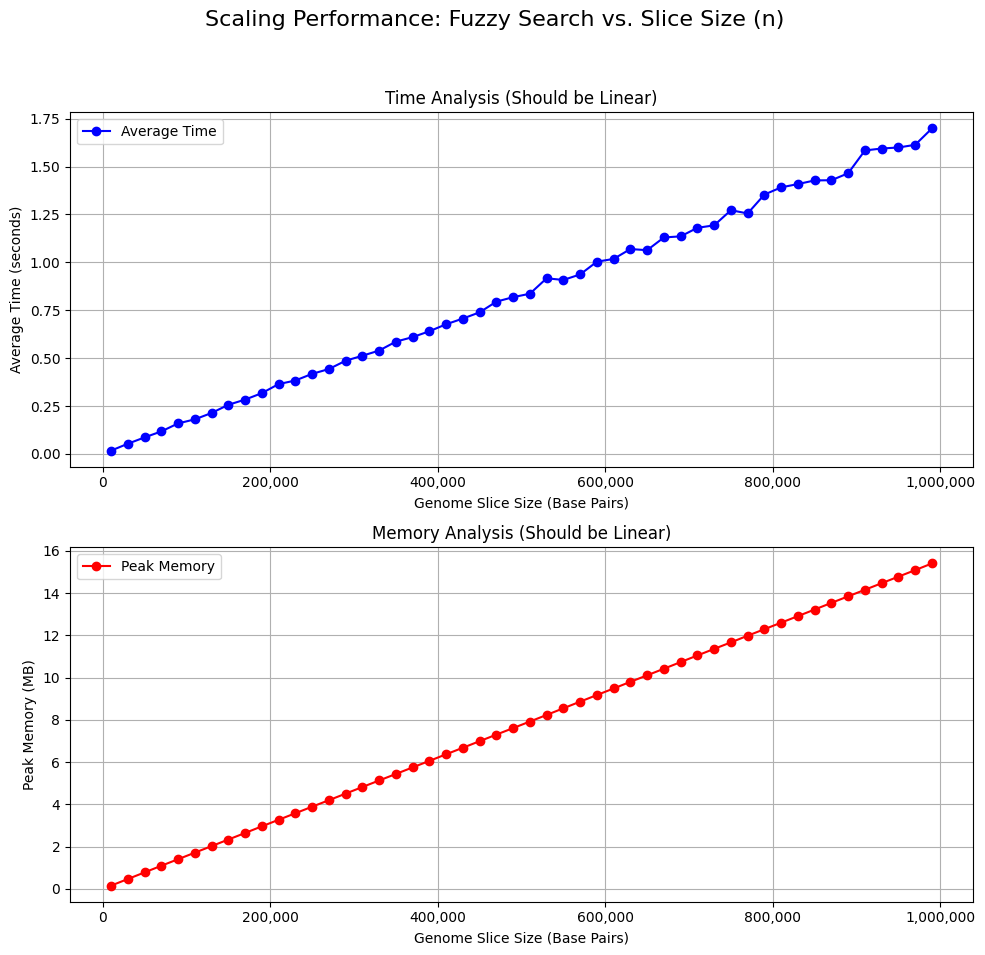

In [2]:
# Run Test 1
run_test_1_slice_size(GENOME_FILEPATH)

## Test 2: Impact of Pattern Length (m)

Tests how the algorithm scales with increasing pattern length. Measures time and memory for patterns ranging from 5 to 100 base pairs.


[--- Test 2: Impact of Pattern Length (m) ---]
Starting analysis on fixed text size: 100,000 bp

--- Testing Pattern Length: 5 bp ---
Running time analysis...
Avg Time: 0.1410 s
Running memory analysis...
Avg Time: 0.1410 s
Running memory analysis...
Peak Memory: 1.64 MB

--- Testing Pattern Length: 10 bp ---
Running time analysis...
Peak Memory: 1.64 MB

--- Testing Pattern Length: 10 bp ---
Running time analysis...
Avg Time: 0.2802 s
Running memory analysis...
Avg Time: 0.2802 s
Running memory analysis...
Peak Memory: 1.53 MB

--- Testing Pattern Length: 15 bp ---
Running time analysis...
Peak Memory: 1.53 MB

--- Testing Pattern Length: 15 bp ---
Running time analysis...
Avg Time: 0.4207 s
Running memory analysis...
Avg Time: 0.4207 s
Running memory analysis...
Peak Memory: 1.53 MB

--- Testing Pattern Length: 20 bp ---
Running time analysis...
Peak Memory: 1.53 MB

--- Testing Pattern Length: 20 bp ---
Running time analysis...
Avg Time: 0.5675 s
Running memory analysis...
Avg Time

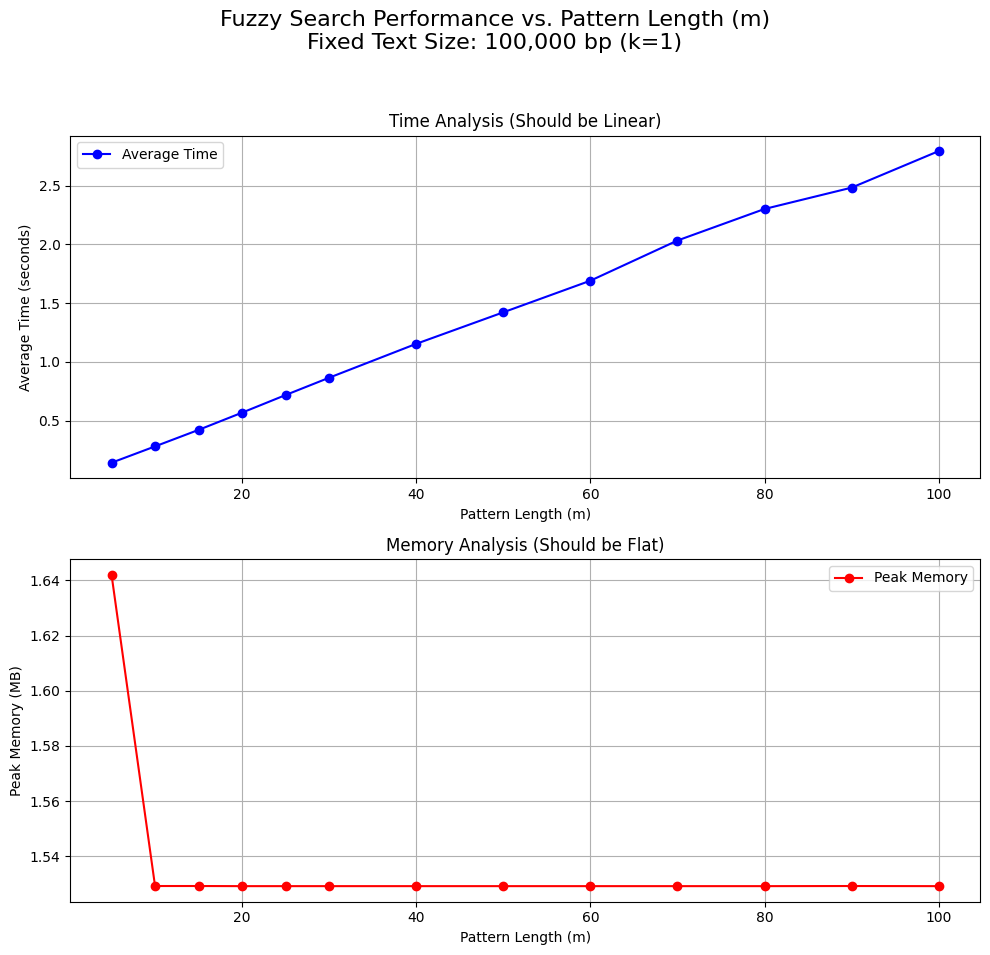

In [3]:
# Run Test 2
run_test_2_pattern_length(GENOME_FILEPATH)

## Test 3: Impact of K-Threshold

Tests how the allowed number of edits (k) affects performance and match counts. Tests k values from 0 to 6.


[--- Test 3: Impact of K-Threshold ---]
Starting analysis on fixed text size: 50,000 bp
Fixed pattern: 'TATAAT'

--- Testing K Threshold: 0 ---
Running time analysis...
Avg Time: 0.0866 s
Running memory analysis...
Avg Time: 0.0866 s
Running memory analysis...
Peak Memory: 0.77 MB
Matches found: 7

--- Testing K Threshold: 1 ---
Running time analysis...
Peak Memory: 0.77 MB
Matches found: 7

--- Testing K Threshold: 1 ---
Running time analysis...
Avg Time: 0.0839 s
Running memory analysis...
Avg Time: 0.0839 s
Running memory analysis...
Peak Memory: 0.78 MB
Matches found: 464

--- Testing K Threshold: 2 ---
Running time analysis...
Peak Memory: 0.78 MB
Matches found: 464

--- Testing K Threshold: 2 ---
Running time analysis...
Avg Time: 0.0862 s
Running memory analysis...
Avg Time: 0.0862 s
Running memory analysis...
Peak Memory: 0.97 MB
Matches found: 5301

--- Testing K Threshold: 3 ---
Running time analysis...
Peak Memory: 0.97 MB
Matches found: 5301

--- Testing K Threshold: 3 ---

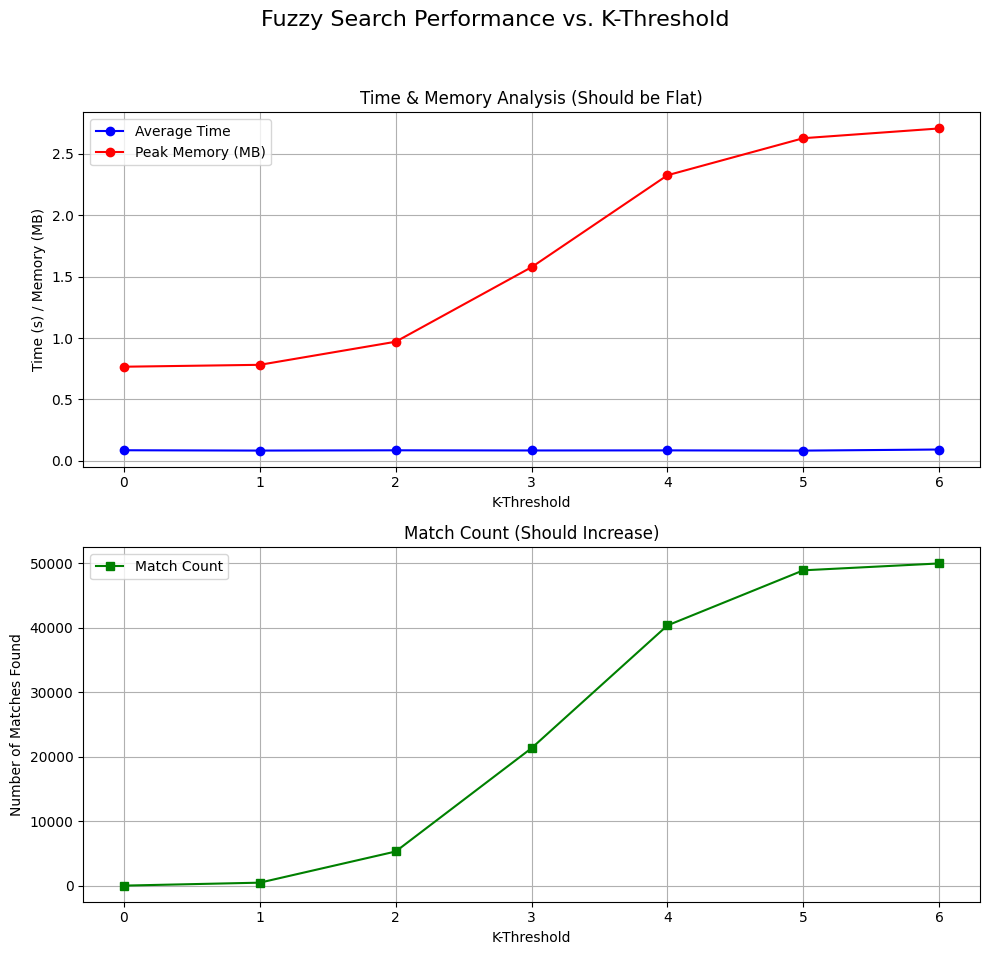

In [4]:
# Run Test 3
run_test_3_k_threshold(GENOME_FILEPATH)

## Test 4: Impact of Data Composition

Compares performance on real genome data vs. synthetic repetitive data. Tests sizes from 10K to 100K base pairs.


[--- Test 4: Impact of Data Composition ---]

--- Running on REAL Genome ---

--- Testing Slice Size: 10,000 bp ---
Running time analysis...
Avg Time: 0.017571 s (over 10 runs)
Running memory analysis...
Avg Time: 0.017571 s (over 10 runs)
Running memory analysis...
Peak Memory: 0.1572 MB

--- Testing Slice Size: 20,000 bp ---
Running time analysis...
Avg Time: 0.032861 s (over 5 runs)
Running memory analysis...
Peak Memory: 0.1572 MB

--- Testing Slice Size: 20,000 bp ---
Running time analysis...
Avg Time: 0.032861 s (over 5 runs)
Running memory analysis...
Peak Memory: 0.3121 MB

--- Testing Slice Size: 30,000 bp ---
Running time analysis...
Peak Memory: 0.3121 MB

--- Testing Slice Size: 30,000 bp ---
Running time analysis...
Avg Time: 0.052500 s (over 5 runs)
Running memory analysis...
Avg Time: 0.052500 s (over 5 runs)
Running memory analysis...
Peak Memory: 0.4679 MB

--- Testing Slice Size: 40,000 bp ---
Running time analysis...
Peak Memory: 0.4679 MB

--- Testing Slice Size: 4

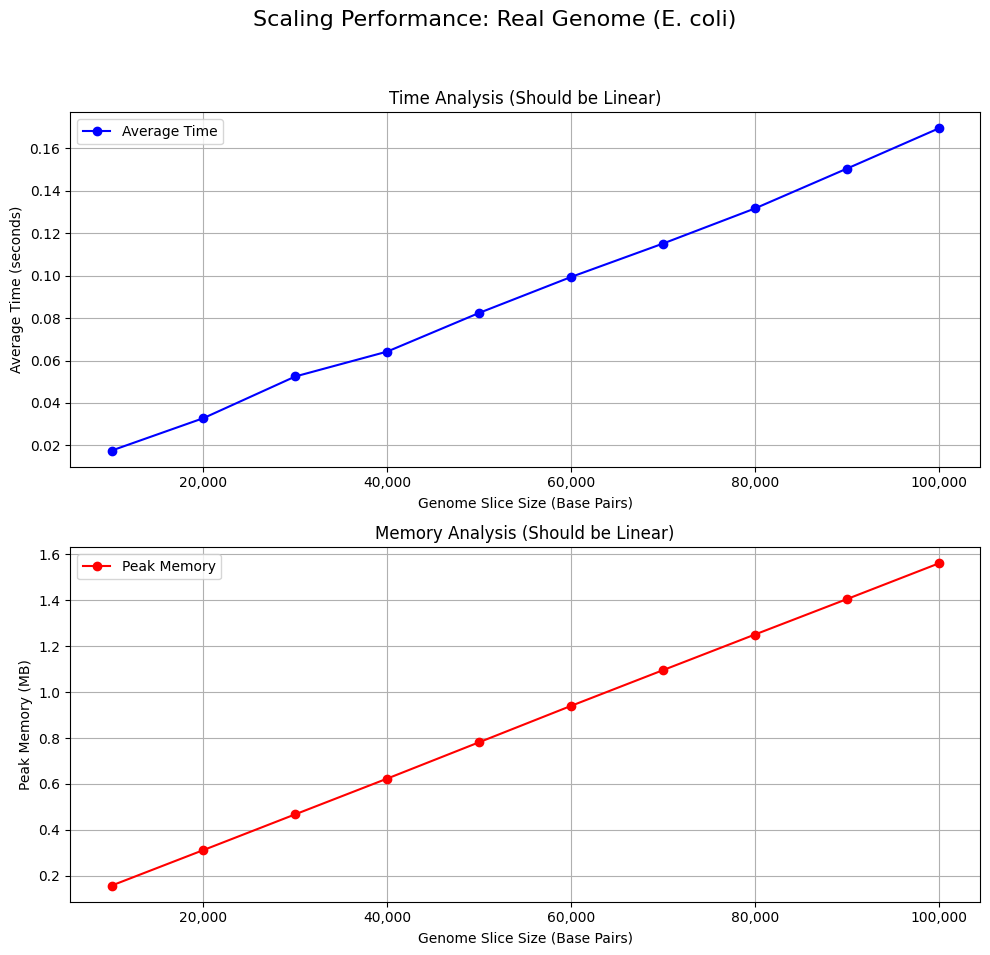


Displaying plots for Fake Repetitive Genome (All 'A's)...


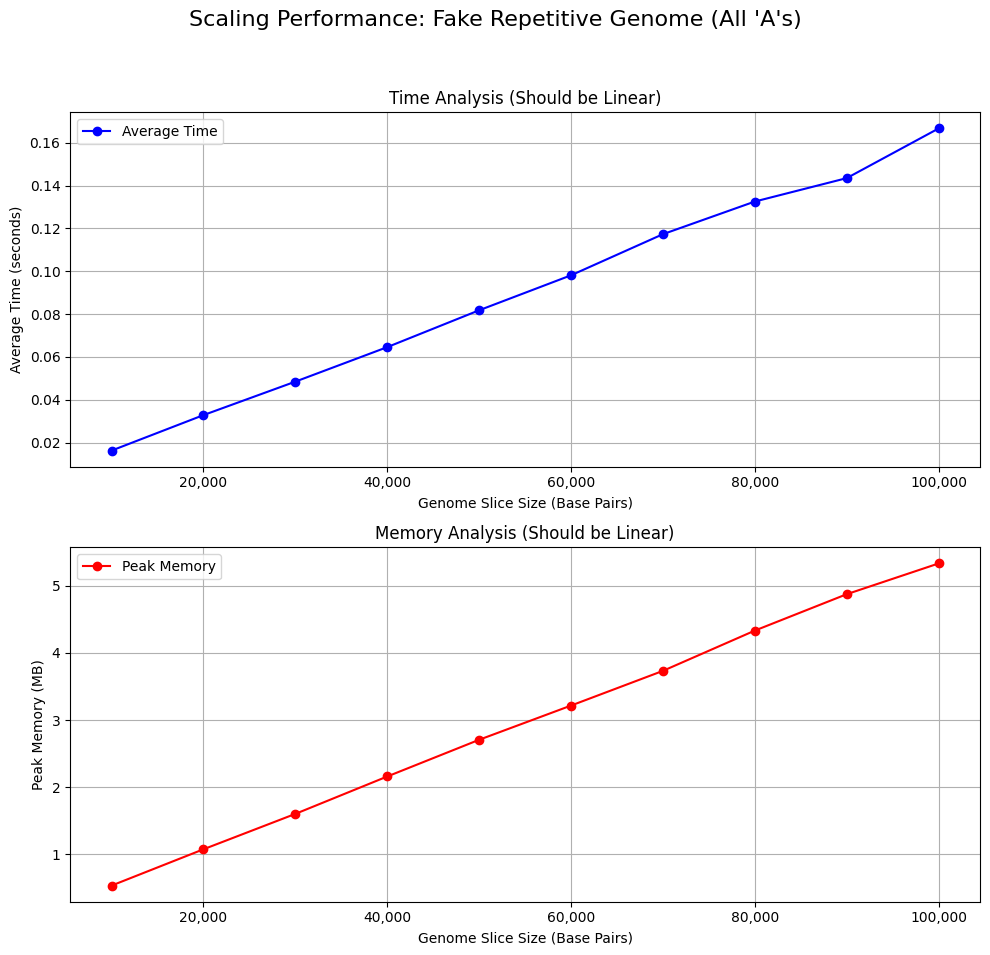

In [5]:
# Run Test 4
run_test_4_data_composition(GENOME_FILEPATH)

## Test 5: Comparison vs. 'regex' Library

Compares the custom Python Levenshtein implementation against the optimized C-based regex library. Tests sizes from 10K to 200K base pairs.


[--- Test 5: Comparison vs. 'regex' Library ---]
Starting comparison analysis for pattern 'TATAAT' (k=1)...

--- Testing Slice Size: 10,000 bp ---
Testing Levenshtein:
  Avg Time: 0.017473 s
  Peak Mem: 0.1564 MB
Testing 'regex' library:
  Avg Time: 0.002349 s
  Peak Mem: 0.0066 MB

--- Testing Slice Size: 30,000 bp ---
Testing Levenshtein:
  Peak Mem: 0.1564 MB
Testing 'regex' library:
  Avg Time: 0.002349 s
  Peak Mem: 0.0066 MB

--- Testing Slice Size: 30,000 bp ---
Testing Levenshtein:
  Avg Time: 0.049669 s
  Avg Time: 0.049669 s
  Peak Mem: 0.4649 MB
Testing 'regex' library:
  Avg Time: 0.006765 s
  Peak Mem: 0.0120 MB

--- Testing Slice Size: 50,000 bp ---
Testing Levenshtein:
  Peak Mem: 0.4649 MB
Testing 'regex' library:
  Avg Time: 0.006765 s
  Peak Mem: 0.0120 MB

--- Testing Slice Size: 50,000 bp ---
Testing Levenshtein:
  Avg Time: 0.080051 s
  Avg Time: 0.080051 s
  Peak Mem: 0.7754 MB
Testing 'regex' library:
  Avg Time: 0.011687 s
  Peak Mem: 0.0211 MB

--- Testing Sli

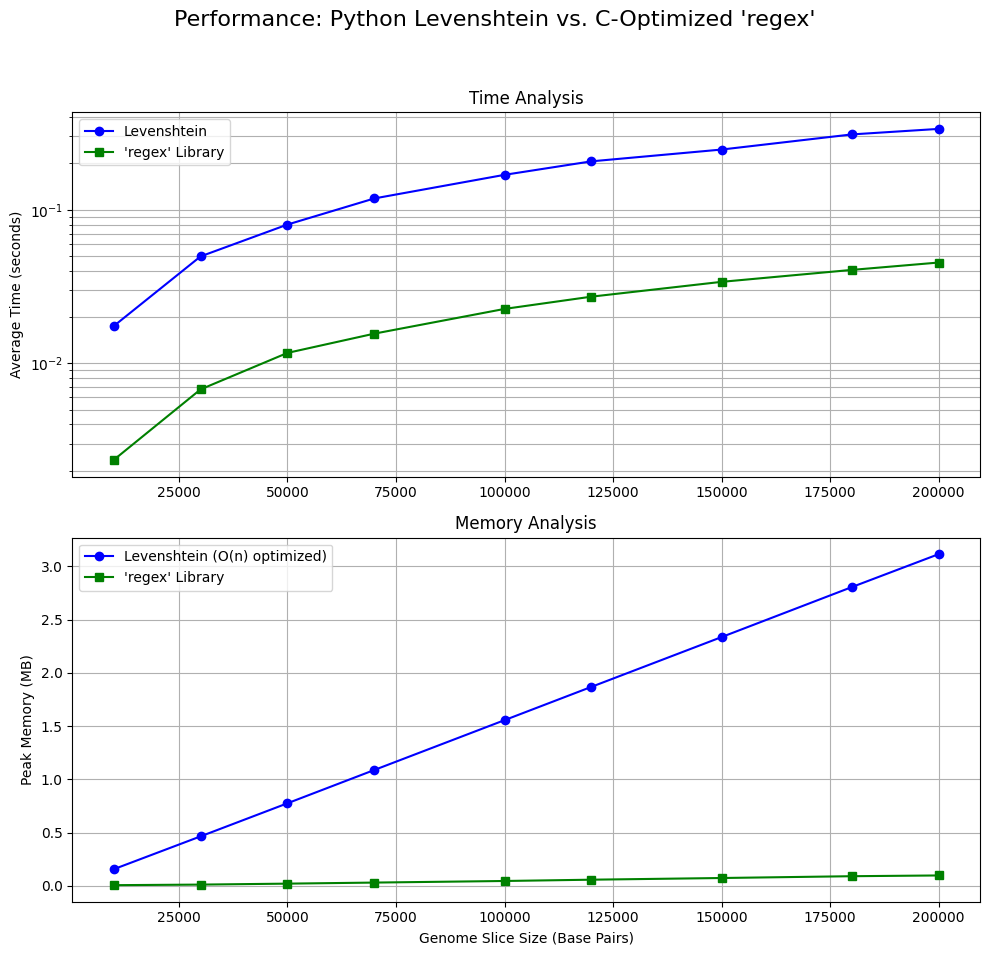

In [10]:
# Run Test 5
run_test_5_regex_comparison(GENOME_FILEPATH)